In [1]:
import sys
sys.path.insert(0, '/opt/ros/noetic/lib/python3/dist-packages')

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from tf.transformations import quaternion_multiply, quaternion_inverse

In [3]:
csv_fn = '../static_60s.csv'

In [4]:
from collections import namedtuple
IMU_Frame = namedtuple('IMU_Frame',
                       ['idx', 'or_qtn', 'ag_vel', 'ln_acc', 'secs', 'nsecs'])


def parse_imu_csv(csv_fn):
    def convert(strlist):
        """ '['x', 'y', 'z']' => [x, y, z] """
        return [float(str) for str in strlist[1:-1].split(', ')]

    csv_reader = csv.reader(open(csv_fn))
    print(csv_reader.__next__())  # use `__next__` to skip csv title

    imu_msg = []
    for line in csv_reader:
        idx = int(line[0])
        orientation = convert(line[1])
        angular_velocity = convert(line[2])
        linear_acceleration = convert(line[3])
        secs = float(line[4])
        nsecs = float(line[5])

        imu_msg.append(IMU_Frame(idx, orientation, angular_velocity,
                                 linear_acceleration, secs, nsecs))
    return imu_msg

imu_msg = parse_imu_csv(csv_fn)
print(len(imu_msg))

['seq', 'orientation', 'angular velocity', 'linear acceleration', 'secs', 'nsecs']
12321


In [5]:
class VechicleInfo:
    def __init__(self):
        self.pos = []
        self.vel = []
        self.acc = []

    def append(self, pos, vel, acc):
        self.pos.append(pos)
        self.vel.append(vel)
        self.acc.append(acc)


def compute_vehicle_info(imu_msg):
    veh_info = VechicleInfo()
    for i, imu_frame in enumerate(imu_msg):
        q = imu_frame.or_qtn
        a = [*imu_frame.ln_acc, 0]
        world_acc = quaternion_multiply(quaternion_multiply(q, a),
                                        quaternion_inverse(q))[0:3]
        if i == 0:
            pre_imuframe = imu_frame
            veh_info.append(np.zeros((3)), np.zeros((3)), world_acc)
            continue

        dt = (imu_frame.secs - pre_imuframe.secs) + \
            (imu_frame.nsecs - pre_imuframe.nsecs)/1e9

        world_vel = veh_info.vel[-1] + (world_acc + veh_info.acc[-1]) * dt / 2
        world_pos = veh_info.pos[-1] + (veh_info.vel[-1] + world_vel) * dt / 2
        veh_info.append(world_pos, world_vel, world_acc)
        pre_imuframe = imu_frame

    return veh_info

veh_info = compute_vehicle_info(imu_msg)
print(len(veh_info.pos))

12321


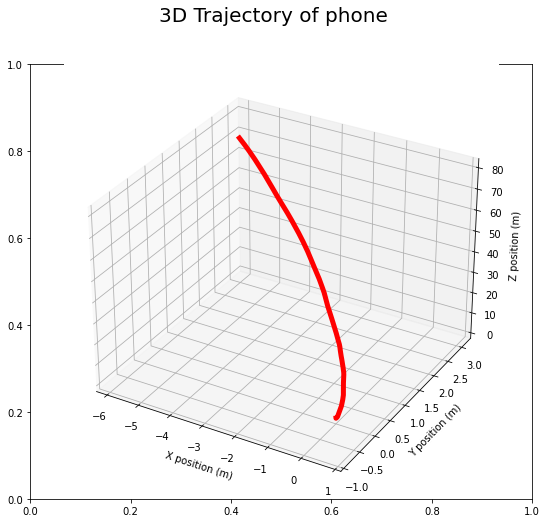

In [6]:
def plot_xzy(xyz: np.array):
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]

    # Plot 3D Trajectory
    fig3, ax = plt.subplots(figsize=(9, 8))
    fig3.suptitle('3D Trajectory of phone', fontsize=20)
    ax = plt.axes(projection='3d')
    ax.plot3D(x, y, z, c='red', lw=5, label='phone trajectory')
    ax.set_xlabel('X position (m)')
    ax.set_ylabel('Y position (m)')
    ax.set_zlabel('Z position (m)')
    ax.set_xlim(x.min()-1, x.max()+1)
    ax.set_ylim(y.min()-1, y.max()+1)
    ax.set_zlim(z.min()-1, z.max()+1)


plot_xzy(np.array(veh_info.pos))


In [7]:
def plot_2_xzy(xyz1, xyz2, subtitles=['', '']):
    # Plot 3D Trajectory
    fig3 = plt.figure(figsize=(15, 8))
    fig3.suptitle('3D Trajectory of vehicle', fontsize=20)

    layout = 121
    for xyz, title in zip((xyz1, xyz2), subtitles):
        if not isinstance(xyz, np.ndarray):
            xyz = np.array(xyz)
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]
        ax = fig3.add_subplot(layout, projection='3d')
        layout += 1

        ax.set_title(title)
        ax.plot3D(x, y, z, c='red', lw=2, label='')
        ax.set_xlabel('X position (m)')
        ax.set_ylabel('Y position (m)')
        ax.set_zlabel('Z position (m)')
        ax.set_xlim(x.min()-1, x.max()+1)
        ax.set_ylim(y.min()-1, y.max()+1)
        ax.set_zlim(z.min()-1, z.max()+1)


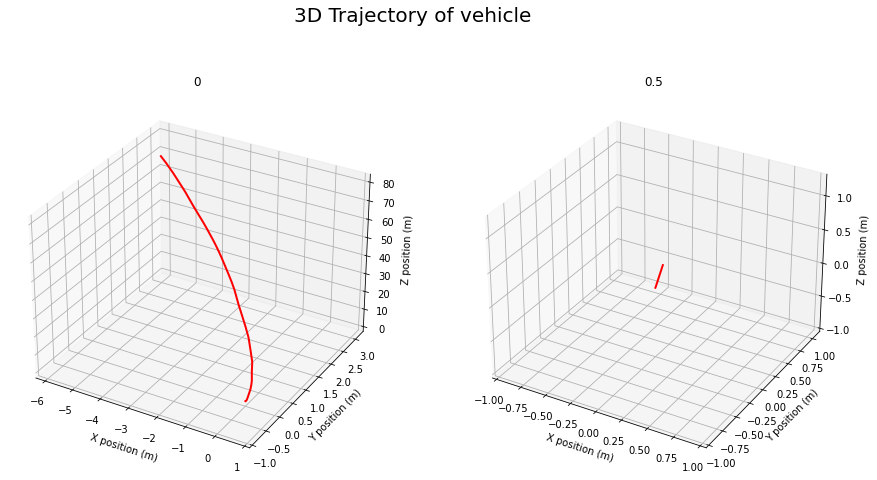

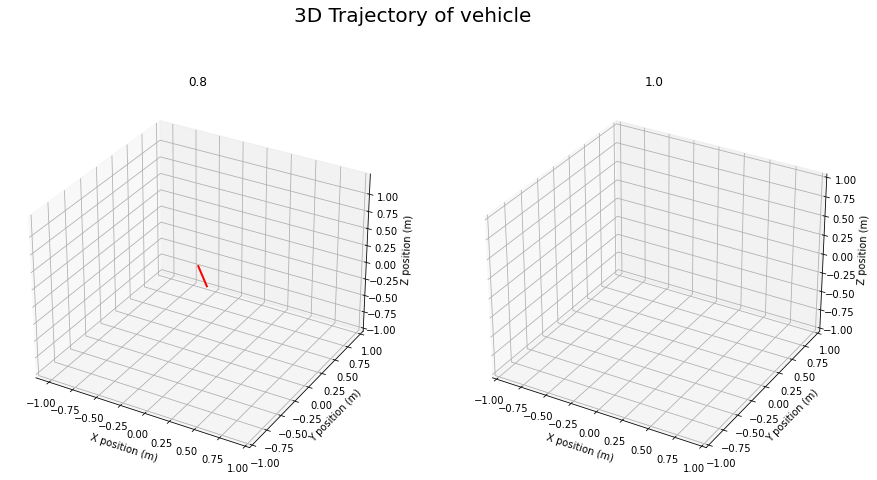

In [8]:
def compute_vehicle_info_v1(imu_msg, constant_noise=0.8):
    veh_info = VechicleInfo()
    for i, imu_frame in enumerate(imu_msg):
        q = imu_frame.or_qtn
        a = [*imu_frame.ln_acc, 0]
        world_acc = quaternion_multiply(quaternion_multiply(q, a),
                                        quaternion_inverse(q))[0:3]

        if sum(map(lambda i : i * i, world_acc)) < constant_noise:
            world_acc = np.array([0., 0., 0.])

        if i == 0:
            pre_imuframe = imu_frame
            veh_info.append(np.zeros((3)), np.zeros((3)), world_acc)
            continue

        dt = (imu_frame.secs - pre_imuframe.secs) + \
            (imu_frame.nsecs - pre_imuframe.nsecs)/1e9

        world_vel = veh_info.vel[-1] + (world_acc + veh_info.acc[-1]) * dt / 2
        world_pos = veh_info.pos[-1] + (veh_info.vel[-1] + world_vel) * dt / 2
        veh_info.append(world_pos, world_vel, world_acc)
        pre_imuframe = imu_frame

    return veh_info

veh_info_remove_acc_bias1 = compute_vehicle_info_v1(imu_msg, 0.5)
veh_info_remove_acc_bias2 = compute_vehicle_info_v1(imu_msg, 0.8)
veh_info_remove_acc_bias3 = compute_vehicle_info_v1(imu_msg, 1.0)

plot_2_xzy(veh_info.pos, veh_info_remove_acc_bias1.pos, ['0', '0.5'])
plot_2_xzy(veh_info_remove_acc_bias2.pos, veh_info_remove_acc_bias3.pos, ['0.8', '1.0'])

del veh_info_remove_acc_bias1, veh_info_remove_acc_bias2, veh_info_remove_acc_bias3

## IIR Filter

In [9]:
class IIR_Filter:
    COEFFICIENTS_LOW_0_HZ = {
        'alpha': [1, -1.979133761292768, 0.979521463540373],
        'beta': [0.000086384997973502, 0.000172769995947004, 0.000086384997973502]
    }

    COEFFICIENTS_LOW_5_HZ = {
        'alpha': [1, -1.80898117793047, 0.827224480562408],
        'beta': [0.095465967120306, -0.172688631608676, 0.095465967120306]
    }

    COEFFICIENTS_HIGH_1_HZ = {
        'alpha': [1, -1.905384612118461, 0.910092542787947],
        'beta': [0.953986986993339, -1.907503180919730, 0.953986986993339]
    }

    def __init__(self, COEFFICIENTS=COEFFICIENTS_LOW_5_HZ) -> None:
        self.alpha = COEFFICIENTS['alpha']
        self.beta = COEFFICIENTS['beta']

        self.a_in = np.zeros((3, 3))
        self.a_out = np.zeros((3, 3))

    def update(self, a):
        self.a_in[:-1] = self.a_in[1:]
        self.a_in[-1] = np.array(a)
        self.a_out[:-1] = self.a_out[1:]

        alpha = self.alpha
        beta = self.beta
        a_in = self.a_in
        a_out = self.a_out
        a_out[2] = alpha[0] * (a_in[2] * beta[0]
                               + a_in[1] * beta[1]
                               + a_in[0] * beta[2]
                               - a_out[1] * alpha[1]
                               - a_out[0] * alpha[2])

        return a_out[2]


In [13]:
def compute_vehicle_info_iir(imu_msg, filter_param, constant_noise=0.0):
    veh_info = VechicleInfo()
    iirfilter = IIR_Filter(filter_param)
    
    for i, imu_frame in enumerate(imu_msg):
        q = imu_frame.or_qtn
        a = iirfilter.update(imu_frame.ln_acc)
        a = [*a, 0]
        world_acc = quaternion_multiply(quaternion_multiply(q, a),
                                        quaternion_inverse(q))[0:3]

        if sum(map(lambda i : i * i, world_acc)) < constant_noise:
            world_acc = np.array([0., 0., 0.])

        if i == 0:
            pre_imuframe = imu_frame
            veh_info.append(np.zeros((3)), np.zeros((3)), world_acc)
            continue

        dt = (imu_frame.secs - pre_imuframe.secs) + \
            (imu_frame.nsecs - pre_imuframe.nsecs)/1e9

        world_vel = veh_info.vel[-1] + (world_acc + veh_info.acc[-1]) * dt / 2
        world_pos = veh_info.pos[-1] + (veh_info.vel[-1] + world_vel) * dt / 2
        veh_info.append(world_pos, world_vel, world_acc)
        pre_imuframe = imu_frame

    return veh_info


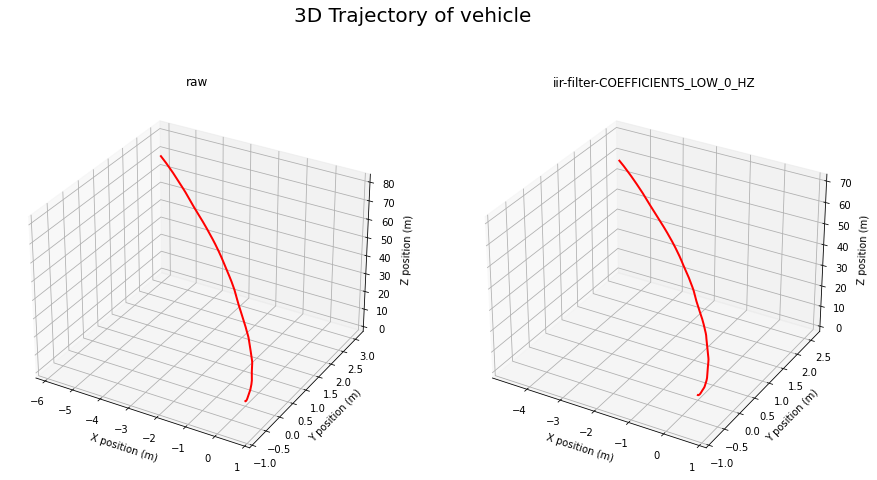

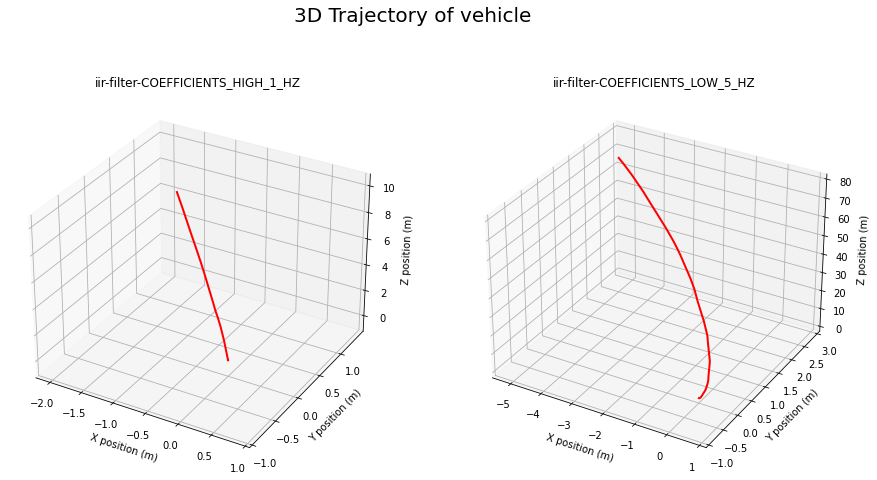

In [14]:
veh_info_iir1 = compute_vehicle_info_iir(imu_msg, IIR_Filter.COEFFICIENTS_LOW_0_HZ)
veh_info_iir2 = compute_vehicle_info_iir(imu_msg, IIR_Filter.COEFFICIENTS_HIGH_1_HZ)
veh_info_iir3 = compute_vehicle_info_iir(imu_msg, IIR_Filter.COEFFICIENTS_LOW_5_HZ)

plot_2_xzy(veh_info.pos, veh_info_iir1.pos, ['raw', 'iir-filter-COEFFICIENTS_LOW_0_HZ'])
plot_2_xzy(veh_info_iir2.pos, veh_info_iir3.pos, ['iir-filter-COEFFICIENTS_HIGH_1_HZ', 'iir-filter-COEFFICIENTS_LOW_5_HZ'])

del veh_info_iir1, veh_info_iir2, veh_info_iir3

['seq', 'orientation', 'angular velocity', 'linear acceleration', 'secs', 'nsecs']


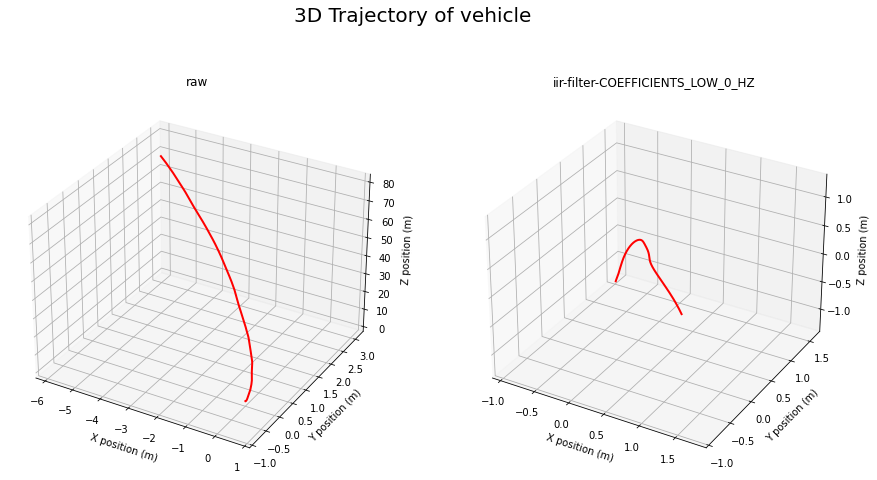

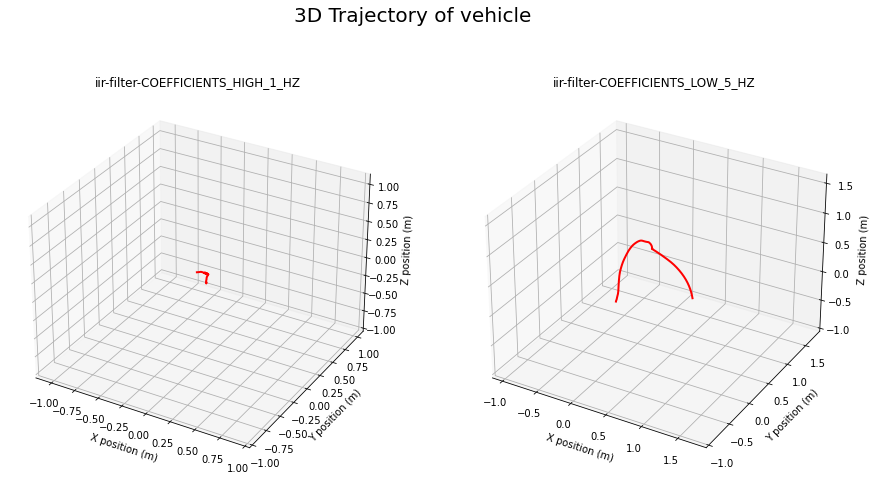

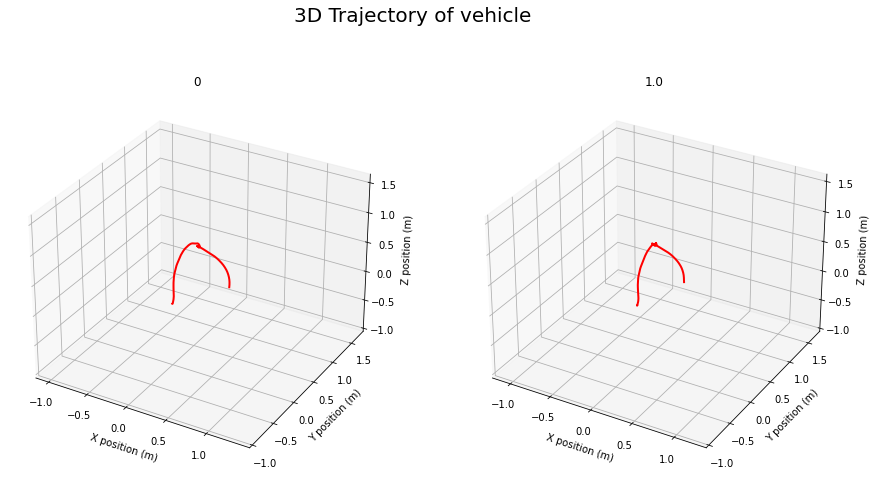

In [15]:
csv_fn = '../half_circle.csv'
imu_msg = parse_imu_csv(csv_fn)
veh_info_iir1 = compute_vehicle_info_iir(imu_msg, IIR_Filter.COEFFICIENTS_LOW_0_HZ)
veh_info_iir2 = compute_vehicle_info_iir(imu_msg, IIR_Filter.COEFFICIENTS_HIGH_1_HZ)
veh_info_iir3 = compute_vehicle_info_iir(imu_msg, IIR_Filter.COEFFICIENTS_LOW_5_HZ)

plot_2_xzy(veh_info.pos, veh_info_iir1.pos, ['raw', 'iir-filter-COEFFICIENTS_LOW_0_HZ'])
plot_2_xzy(veh_info_iir2.pos, veh_info_iir3.pos, ['iir-filter-COEFFICIENTS_HIGH_1_HZ', 'iir-filter-COEFFICIENTS_LOW_5_HZ'])


veh_info_remove_acc_bias1 = compute_vehicle_info_v1(imu_msg, 0.5)
veh_info_remove_acc_bias2 = compute_vehicle_info_v1(imu_msg, 1.0)
plot_2_xzy(veh_info_remove_acc_bias1.pos, veh_info_remove_acc_bias2.pos, ['0.5', '1.0'])

del veh_info_iir1, veh_info_iir2, veh_info_iir3
del veh_info_remove_acc_bias1, veh_info_remove_acc_bias2